## Base Model Result:

In this notebook we will delete unique values columns as data preprocesing and will simply run Naive Bayse model to build a baseline. The next work would be done to improve the base line results

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv("F:/Don't get kicked/data/training.csv")
df_test = pd.read_csv("F:/Don't get kicked/data/test.csv")

In [3]:
print len(df_train)
df_train.head() 

72983


,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [4]:
def remove_col(data_frame):
    
    del(data_frame['RefId'])
    del(data_frame['BYRNO'])
    del(data_frame['VNZIP1'])
    
    return data_frame

In [5]:
# store test data refid for submission dataset 
test_refid = df_test['RefId']

df_train = remove_col(df_train)
df_test = remove_col(df_test)

In [6]:
import h2o
h2o.init(max_mem_size='6G')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,34 mins 32 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 13 days
H2O cluster name:,H2O_from_python_hamza_s81qfp
H2O cluster total nodes:,1
H2O cluster free memory:,5.281 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [15]:
response = 'IsBadBuy'

# upload data to h2o frame
hdf= h2o.H2OFrame(df_train)

# factor the class label
hdf[response]= hdf[response].asfactor()

# create train and validation datasets for model learining with 70 and 30 percent ratio
hdf_train, hdf_validate, hdf_validate_test = hdf.split_frame(ratios=[0.60,0.2], seed=10)


# create input and response column names

input_name= hdf_train.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'PurchDate', u'Auction', u'VehYear', u'VehicleAge', u'Make', u'Model', u'Trim', u'SubModel', u'Color', u'Transmission', u'WheelTypeID', u'WheelType', u'VehOdo', u'Nationality', u'Size', u'TopThreeAmericanName', u'MMRAcquisitionAuctionAveragePrice', u'MMRAcquisitionAuctionCleanPrice', u'MMRAcquisitionRetailAveragePrice', u'MMRAcquisitonRetailCleanPrice', u'MMRCurrentAuctionAveragePrice', u'MMRCurrentAuctionCleanPrice', u'MMRCurrentRetailAveragePrice', u'MMRCurrentRetailCleanPrice', u'PRIMEUNIT', u'AUCGUART', u'VNST', u'VehBCost', u'IsOnlineSale', u'WarrantyCost']


In [16]:
def model_performance(model):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()


In [17]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator

In [18]:
my_nb = H2ONaiveBayesEstimator(seed = 1)
my_nb.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.701500777312
valid accuracy: 0.693122968296


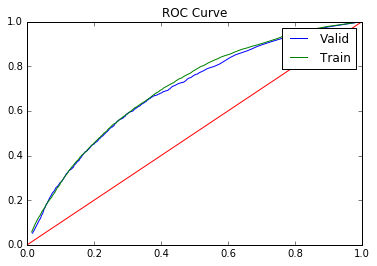

In [19]:
model_performance(my_nb)

In [36]:
my_nb_nfold = H2ONaiveBayesEstimator(seed = 1,
                                     nfolds=20,
                                     fold_assignment="Modulo",
                                     keep_cross_validation_predictions=True,
                                     model_id="my_nb_nfold")
my_nb_nfold.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.701500777312
valid accuracy: 0.693122968296


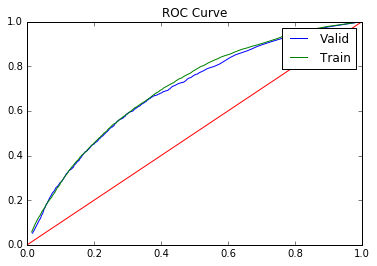

In [37]:
model_performance(my_nb_nfold)

In [20]:
# my_nb.predict(hdf_test)

## Predict with test data

In [21]:
hdf_test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [29]:
def get_submission_df(model, data):
    df_submission = pd.DataFrame()
    prediction = model.predict(data)['predict']

    df_submission['RefId'] = test_refid
    df_submission['IsBadBuy'] = prediction.as_data_frame()
    
    return df_submission


In [31]:
df_submission = get_submission_df(my_nb, hdf_test)

naivebayes prediction progress: |█████████████████████████████████████████| 100%


In [32]:
df_submission.to_csv("F:/Don't get kicked/data/submission.csv", index=False)